In [1]:
!pip install opendatasets
!pip install pandas


In [2]:
import opendatasets as od
import pandas
od.download(
    "https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: arwaelsawy
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset


100%|██████████| 149M/149M [00:01<00:00, 118MB/s]


In [3]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Set the paths for the training and testing directories
train_dir = '/content/brain-tumor-mri-dataset/Training'
test_dir = '/content/brain-tumor-mri-dataset/Testing'

# Load the MobileNetV2 base model without the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Modify the model architecture
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout layer
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Define the hyperparameters
learning_rate = 0.0001  # Adjusted learning rate
batch_size = 32
epochs = 20

# Create the image data generators for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,  # Add rotation augmentation
    brightness_range=[0.8, 1.2],  # Adjust brightness
    vertical_flip=True)  # Add vertical flip

test_datagen = ImageDataGenerator(rescale=1./255)

# Load the training and testing data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[early_stopping]
)

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.4f}')


9406464/9406464 [==============================] - 0s 0us/step
Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Epoch 1/20
178/178 [==============================] - 384s 2s/step - loss: 1.0250 - accuracy: 0.5750 - val_loss: 0.7174 - val_accuracy: 0.7180
Epoch 2/20
178/178 [==============================] - 424s 2s/step - loss: 0.6569 - accuracy: 0.7456 - val_loss: 0.6444 - val_accuracy: 0.7359
Epoch 3/20
178/178 [==============================] - 397s 2s/step - loss: 0.5496 - accuracy: 0.7956 - val_loss: 0.5665 - val_accuracy: 0.7773
Epoch 4/20
178/178 [==============================] - 411s 2s/step - loss: 0.4932 - accuracy: 0.8148 - val_loss: 0.5227 - val_accuracy: 0.7898
Epoch 5/20
178/178 [==============================] - 416s 2s/step - loss: 0.4504 - accuracy: 0.8363 - val_loss: 0.5284 - val_accuracy: 0.7937
Epoch 6/20
178/178 [==============================] - 373s 2s/step - loss: 0.4273 - accuracy: 0.8442 - val_loss: 0.5044 - val_accuracy: 0.

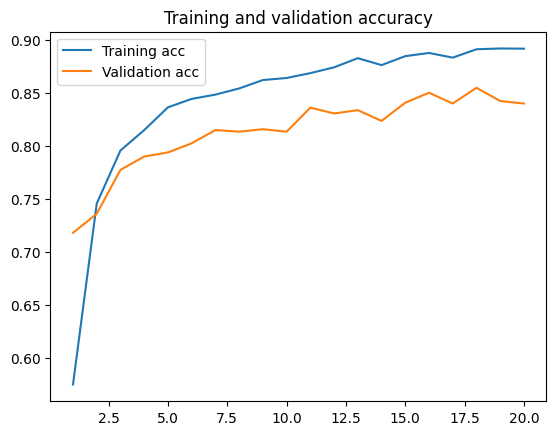

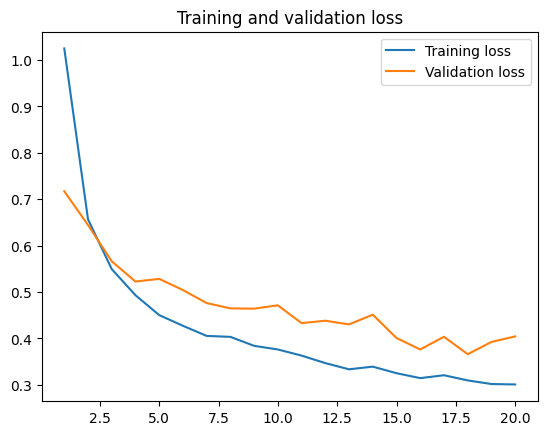

In [4]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()